,RSA,2,1,764.7000002179993,2425.799999400624
0,RSA,2,2,135.300001,1609.300001
1,RSA,2,3,123.400001,903.800001
2,RSA,2,4,90.599999,895.800000
3,RSA,2,5,128.000001,1214.000000
4,RSA,2,6,161.600001,1209.500000


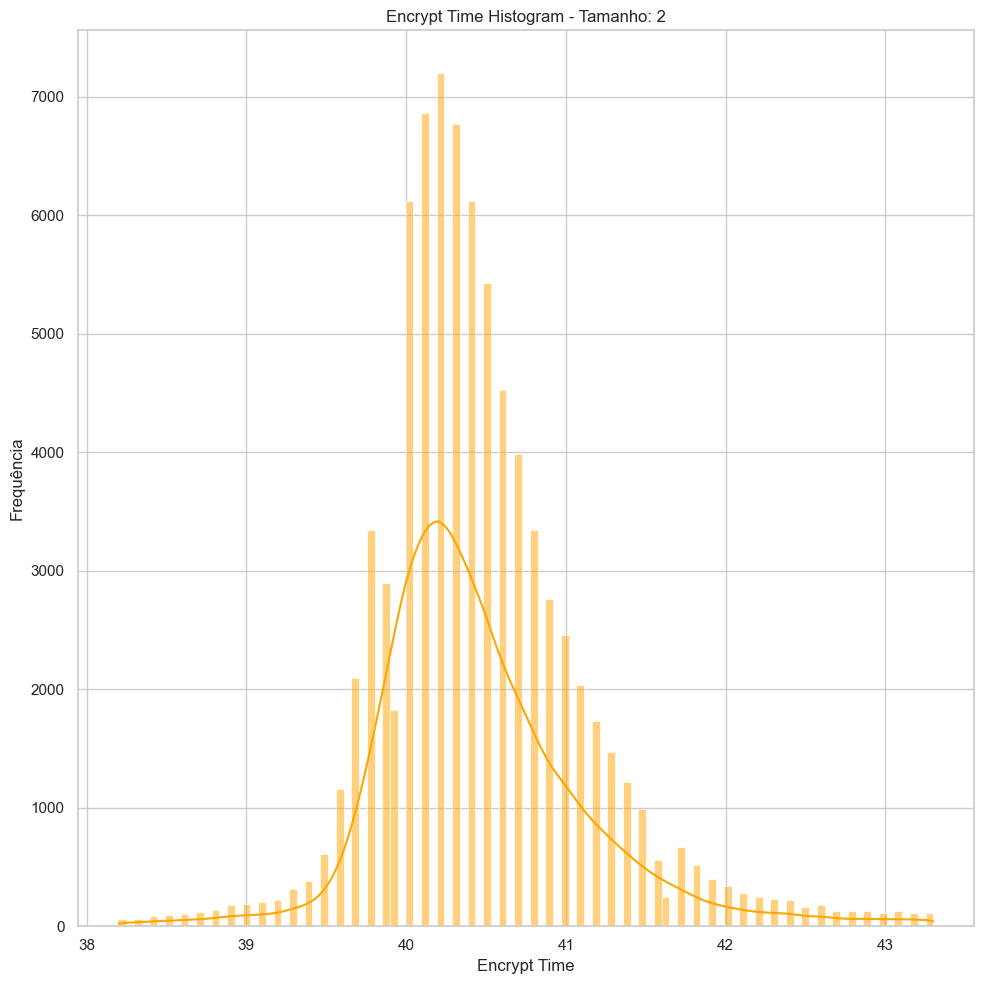

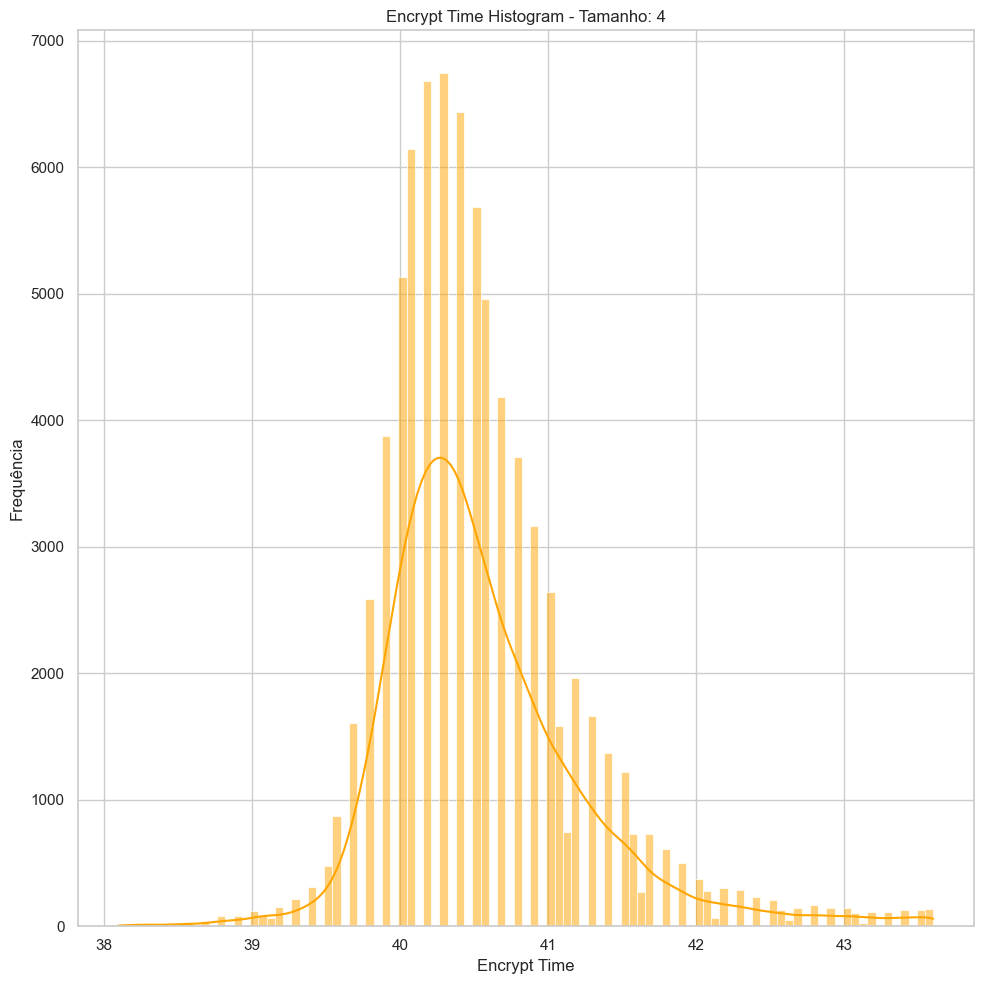

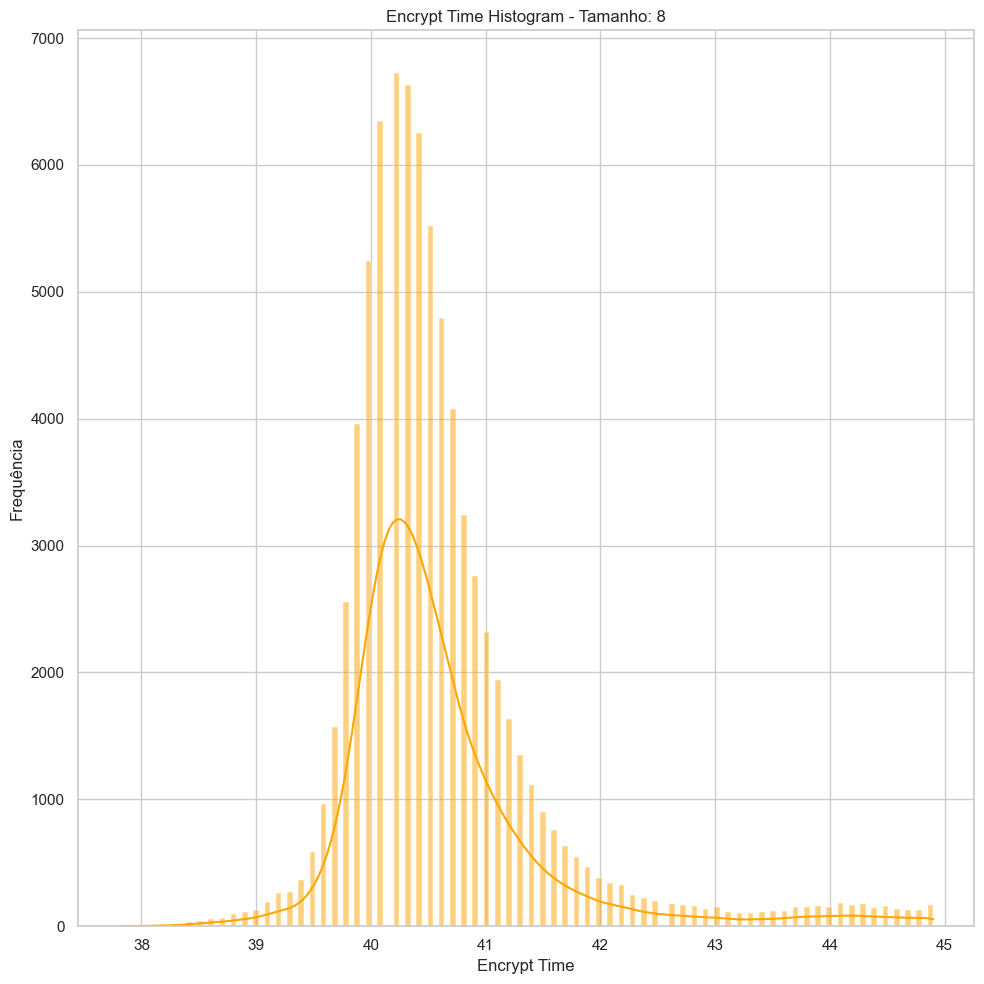

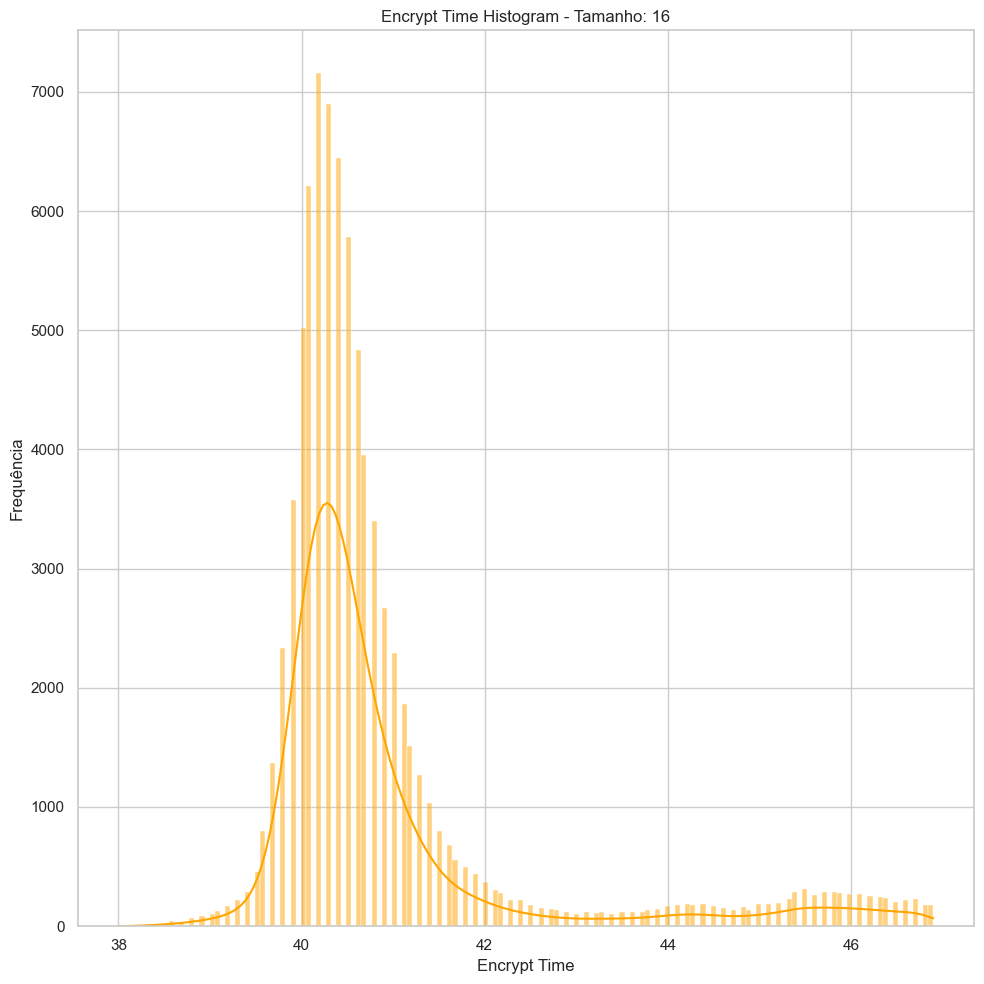

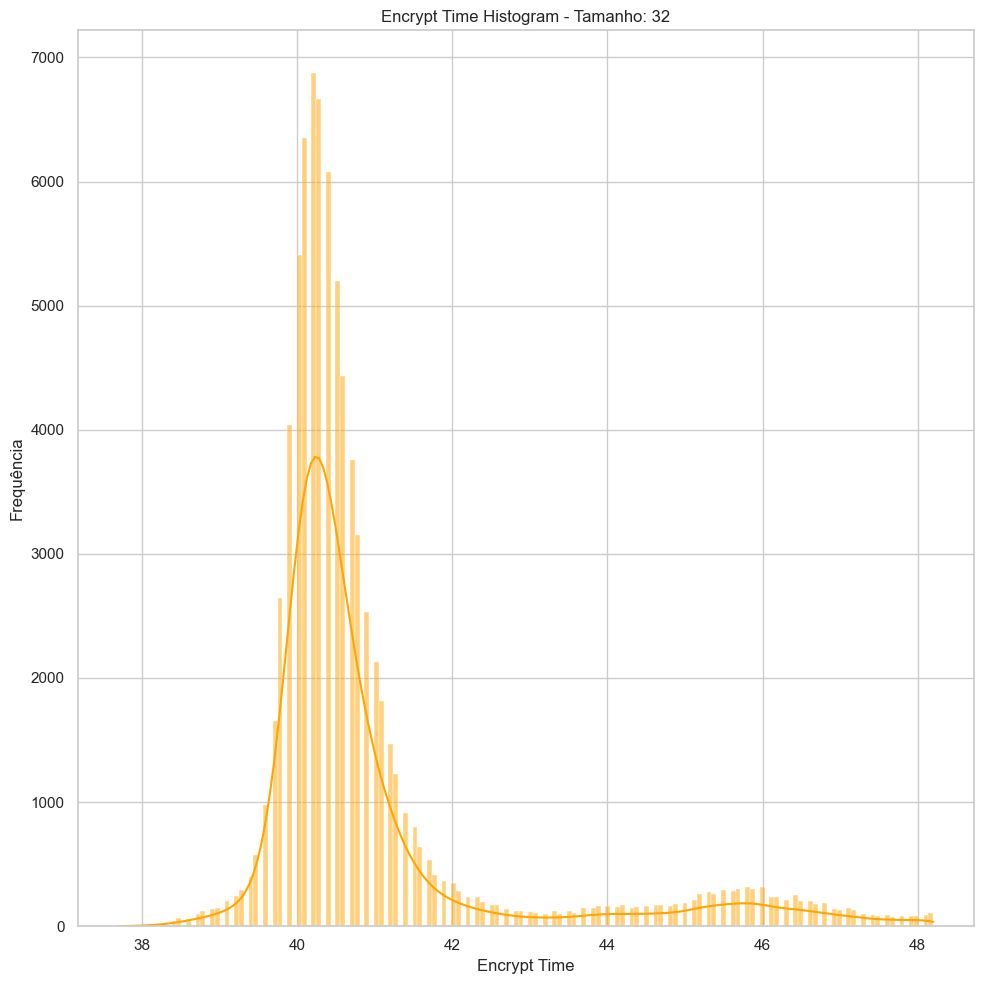

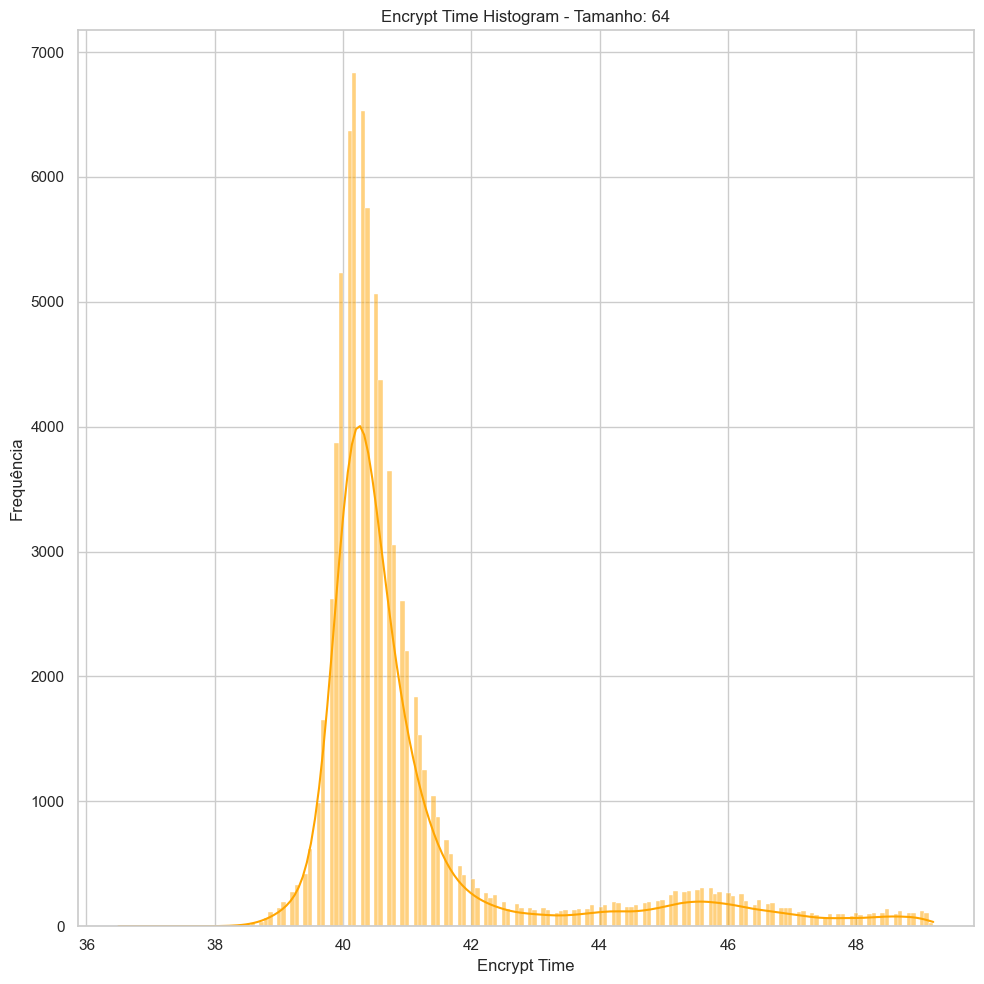

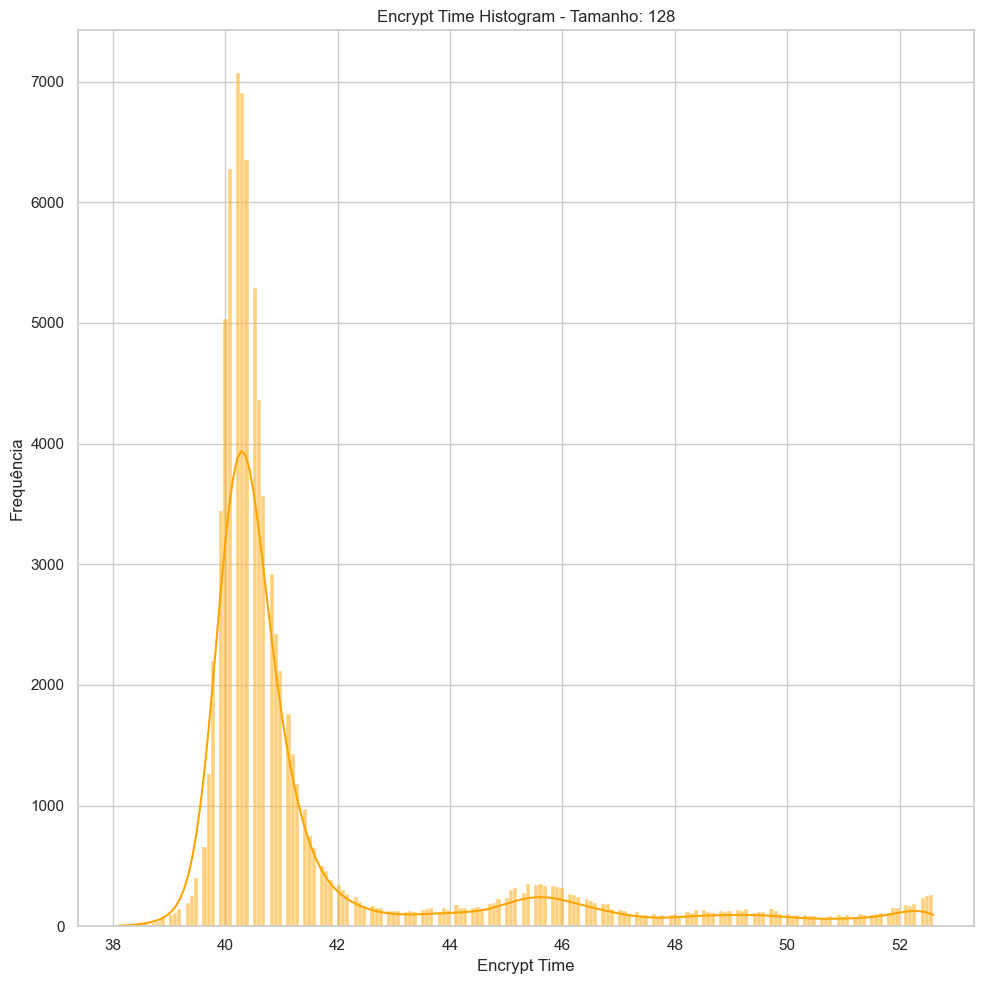

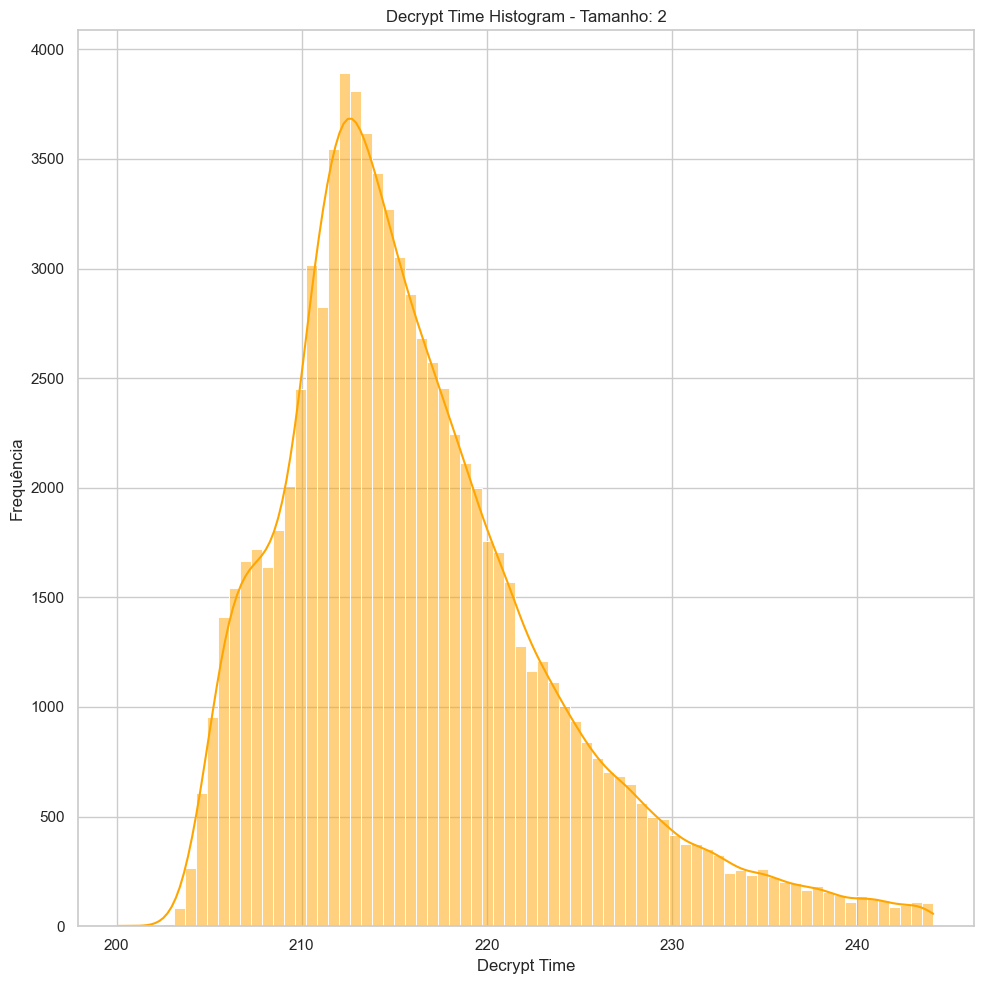

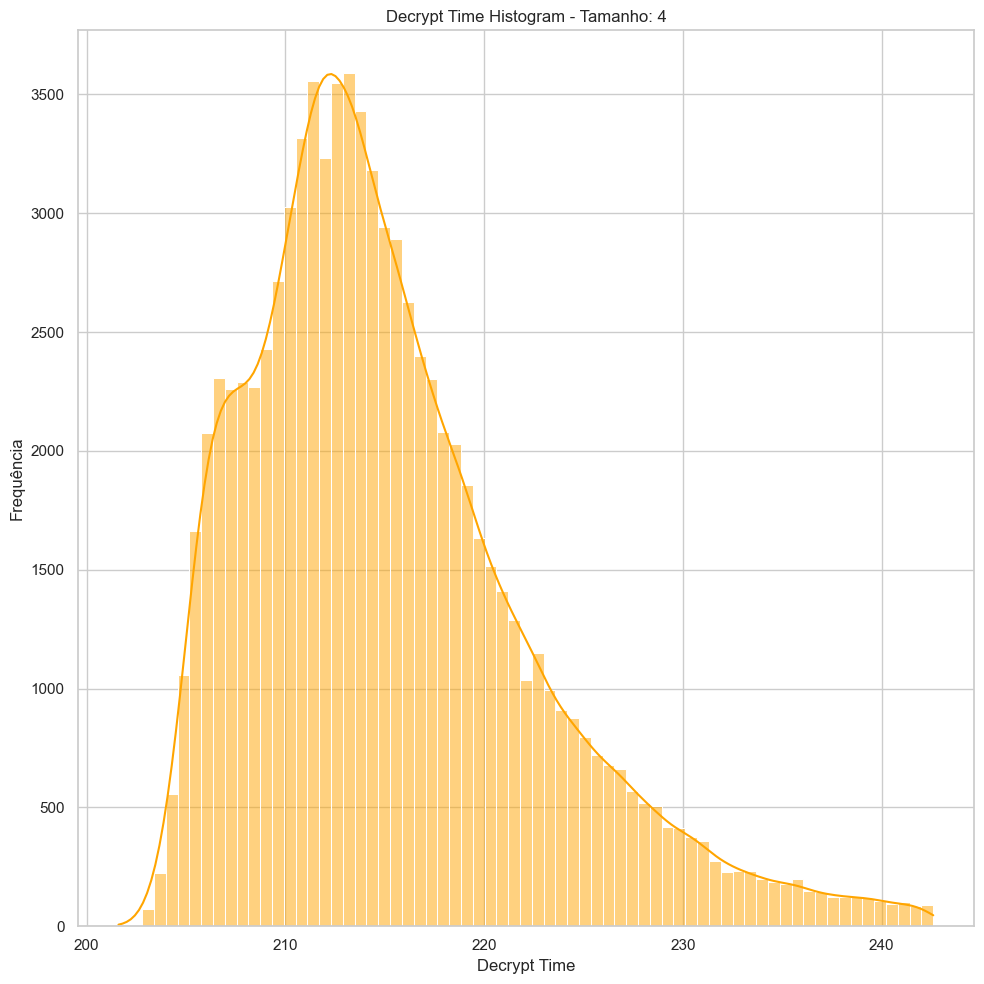

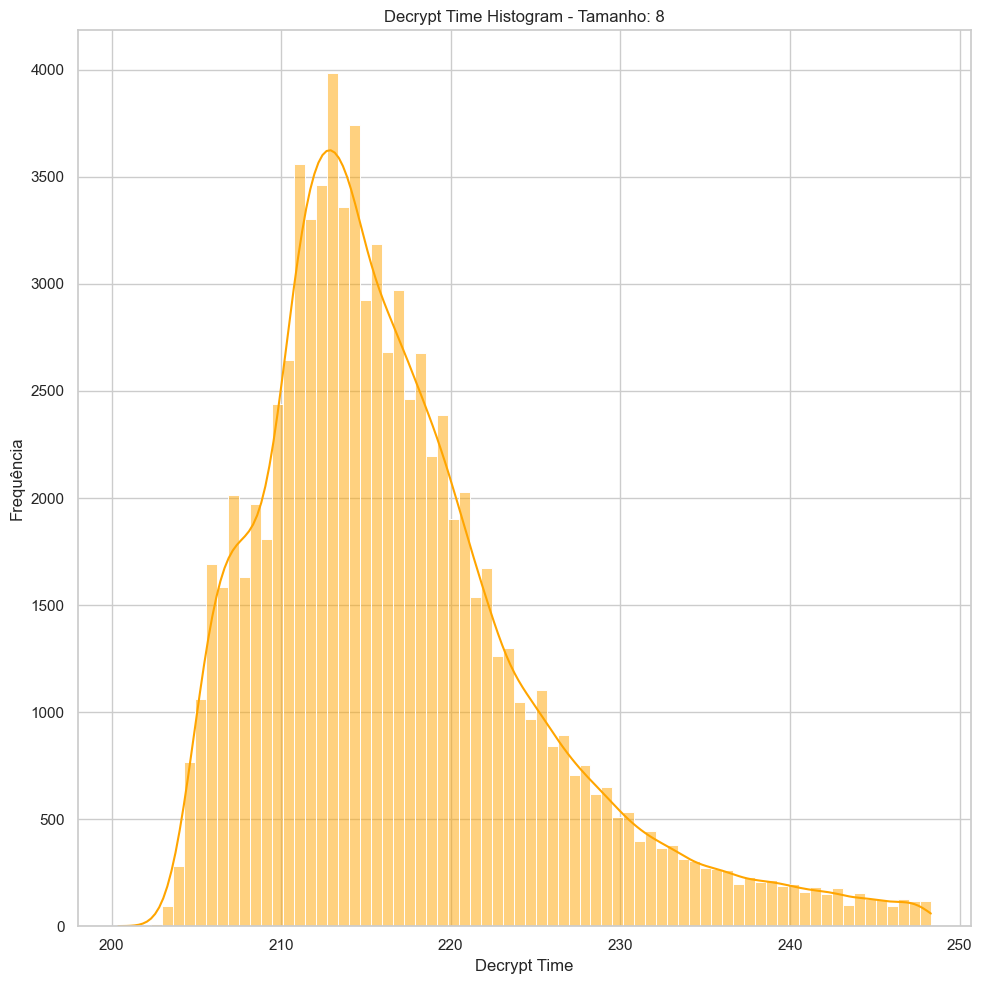

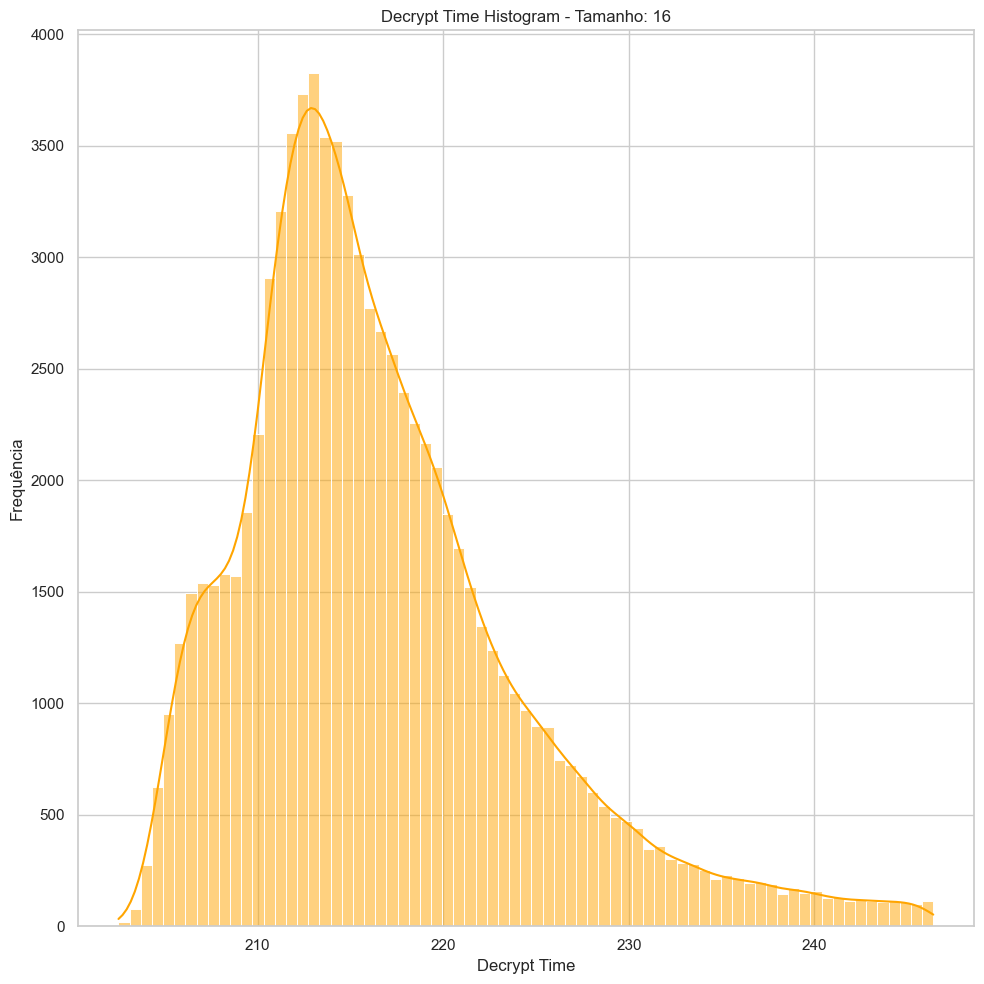

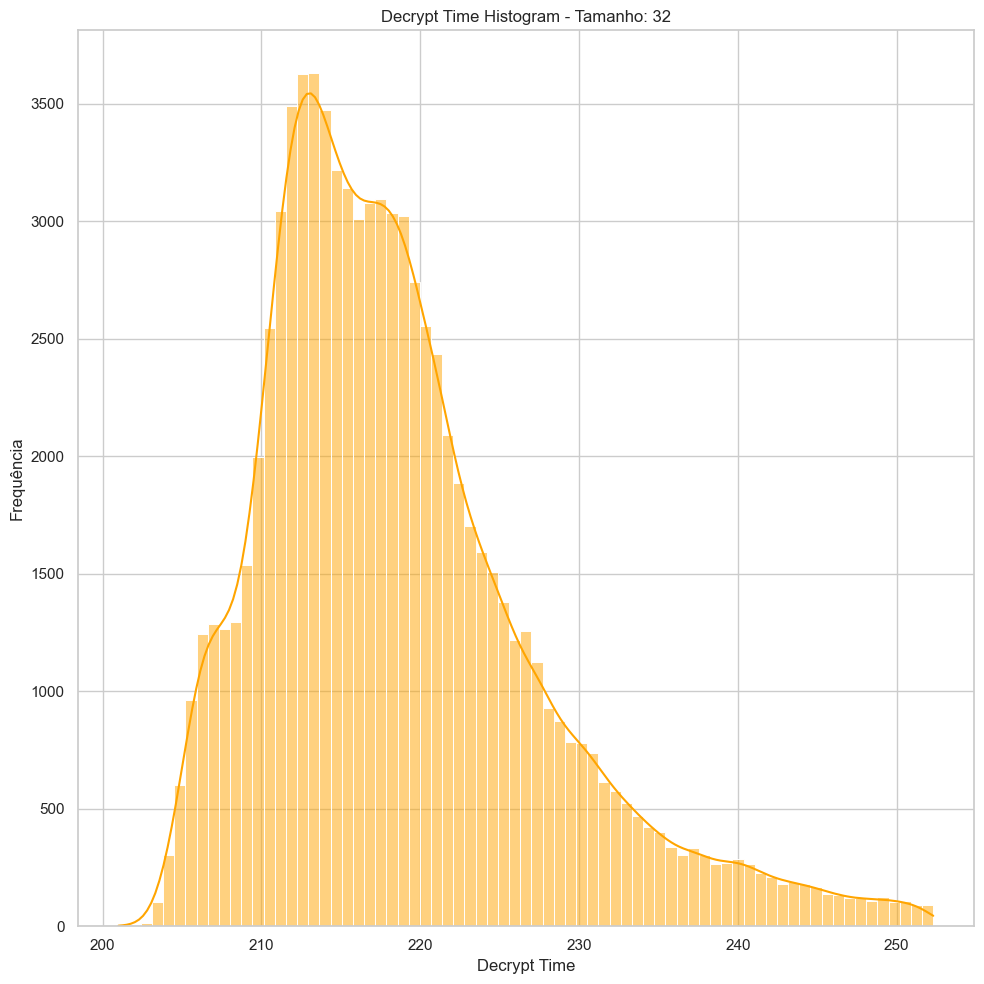

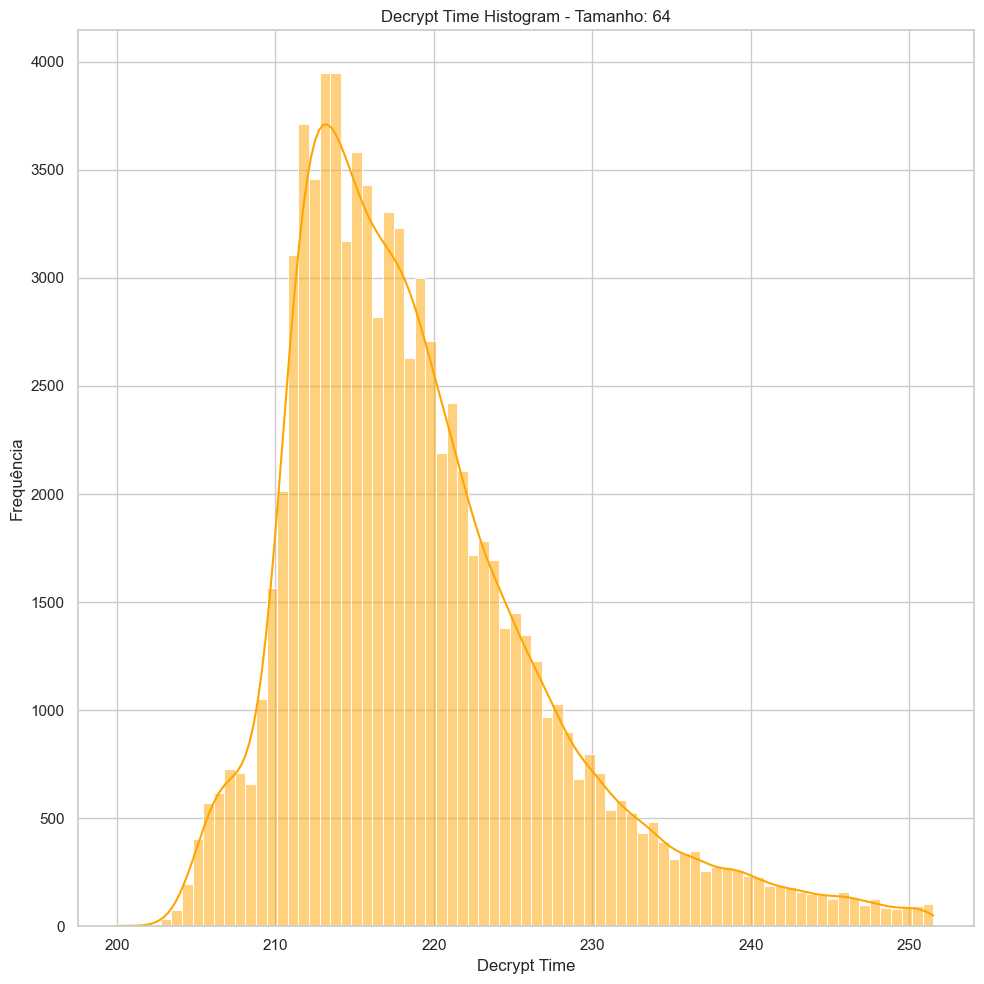

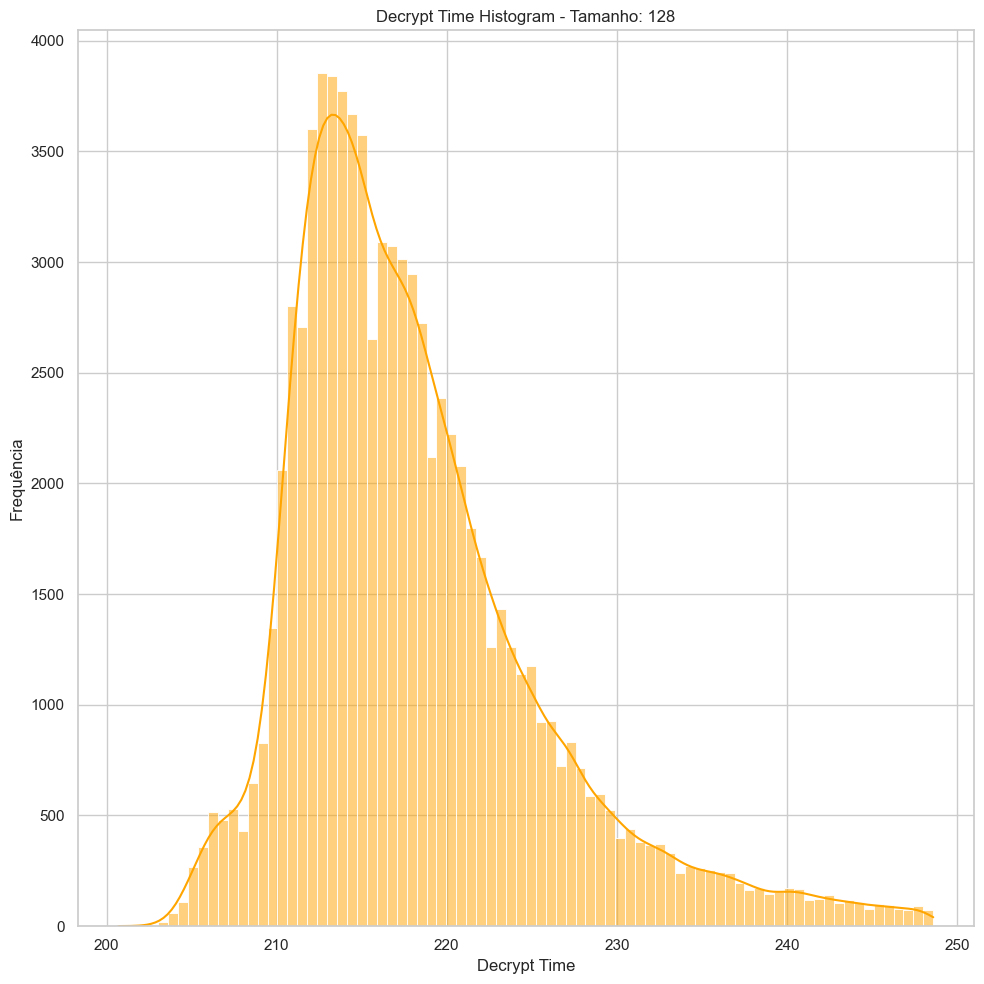

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import iqr

# Lê o ficheiro CSV
df = pd.read_csv('rsa_s.csv')

# Remove linhas com valores nulos nas colunas necessárias
df = df.dropna(subset=['tempo_incrypt', 'tempo_decrypt', 'tamanho'])

# Função para remover outliers usando o método IQR
def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr_value = q3 - q1
    lower = q1 - 1.5 * iqr_value
    upper = q3 + 1.5 * iqr_value
    return data[(data >= lower) & (data <= upper)]

# Estilo do gráfico
sns.set(style='whitegrid')

# Loop por cada tamanho de ficheiro único para tempo_incrypt
for tamanho_valor in df['tamanho'].unique():
    subset = df[df['tamanho'] == tamanho_valor]['tempo_incrypt']
    subset_clean = remove_outliers(subset)


    # Escolher o número ideal de bins com base na regra de Freedman-Diaconis
    bin_width = 2 * iqr(subset_clean) / (len(subset_clean) ** (1/3))
    bin_width *= 1.5  # Aumenta a largura dos bins em 50%
    if bin_width == 0:
        continue  # Evita erro se IQR for 0
    bins = int((subset_clean.max() - subset_clean.min()) / bin_width)

    # Plot do histograma
    plt.figure(figsize=(10,10))
    sns.histplot(subset_clean, bins=bins, kde=True, color='orange')
    plt.title(f'Encrypt Time Histogram - Tamanho: {tamanho_valor}')
    plt.xlabel('Encrypt Time')
    plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()

# Loop por cada tamanho de ficheiro único para tempo_decrypt
for tamanho_valor in df['tamanho'].unique():
    subset = df[df['tamanho'] == tamanho_valor]['tempo_decrypt']
    subset_clean = remove_outliers(subset)

    if len(subset_clean) < 50:
        continue  # Ignora se menos de 50 amostras após remover outliers

    # Escolher o número ideal de bins com base na regra de Freedman-Diaconis
    bin_width = 2 * iqr(subset_clean) / (len(subset_clean) ** (1/3))
    bin_width *= 1.5  # Aumenta a largura dos bins em 50%
    if bin_width == 0:
        continue  # Evita erro se IQR for 0
    bins = int((subset_clean.max() - subset_clean.min()) / bin_width)

    # Plot do histograma
    plt.figure(figsize=(10,10))
    sns.histplot(subset_clean, bins=bins, kde=True, color='orange')
    plt.title(f'Decrypt Time Histogram - Tamanho: {tamanho_valor}')
    plt.xlabel('Decrypt Time')
    plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()

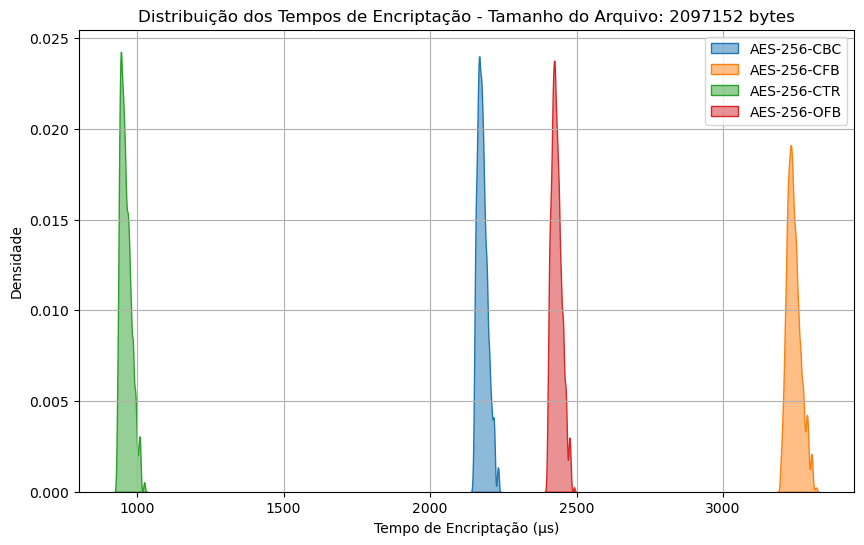

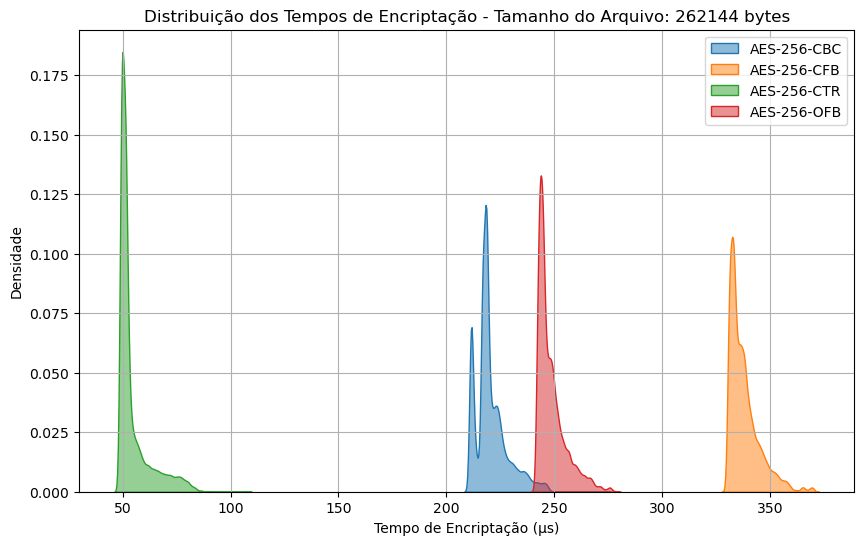

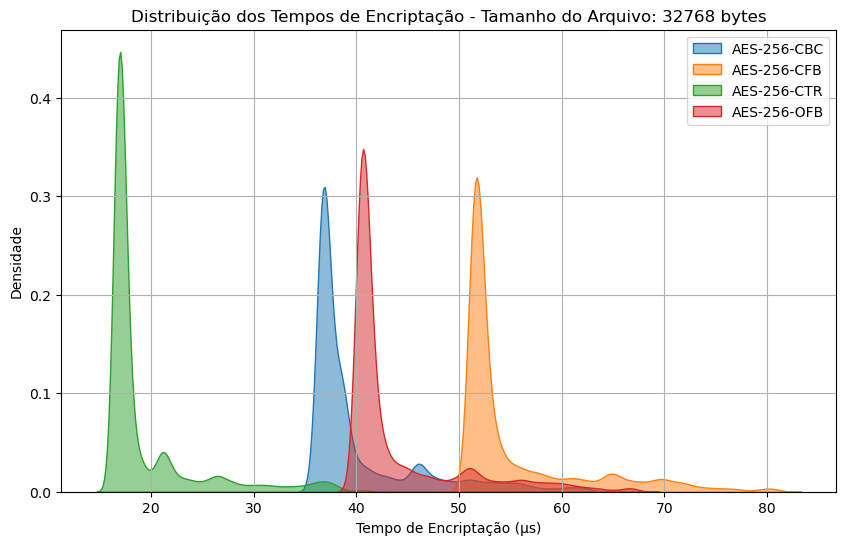

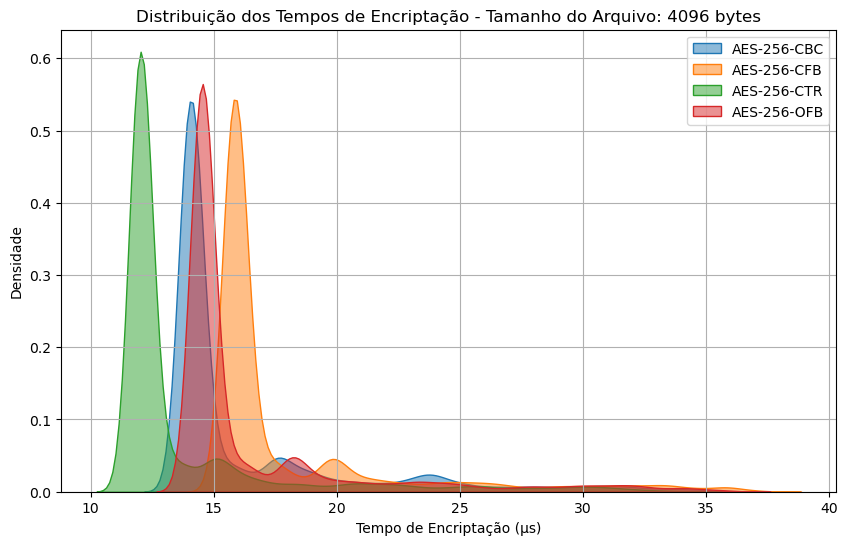

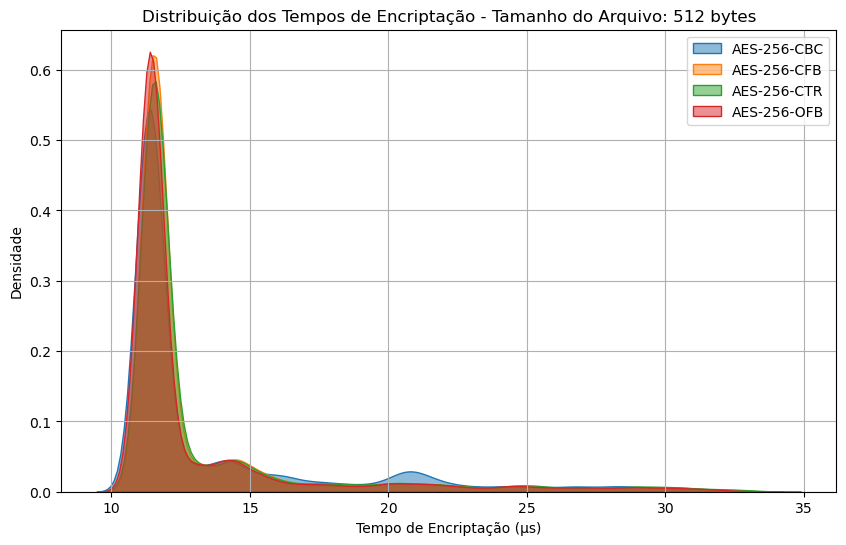

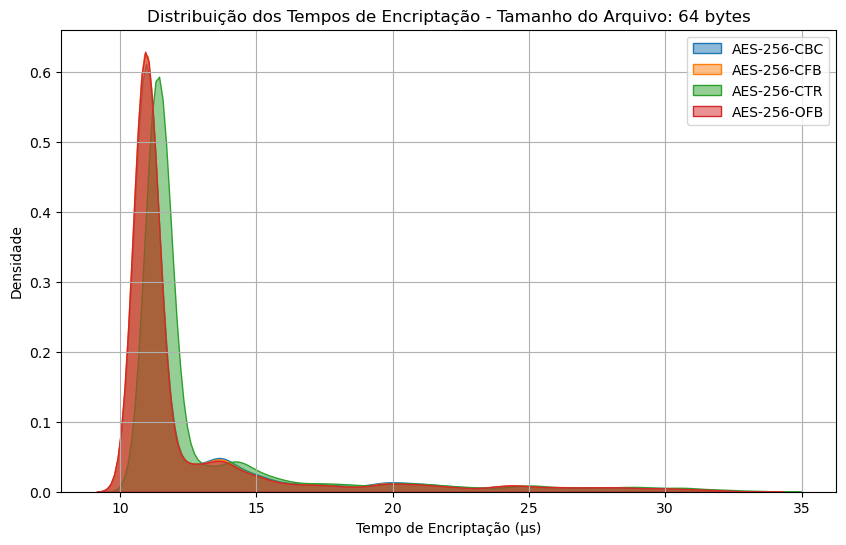

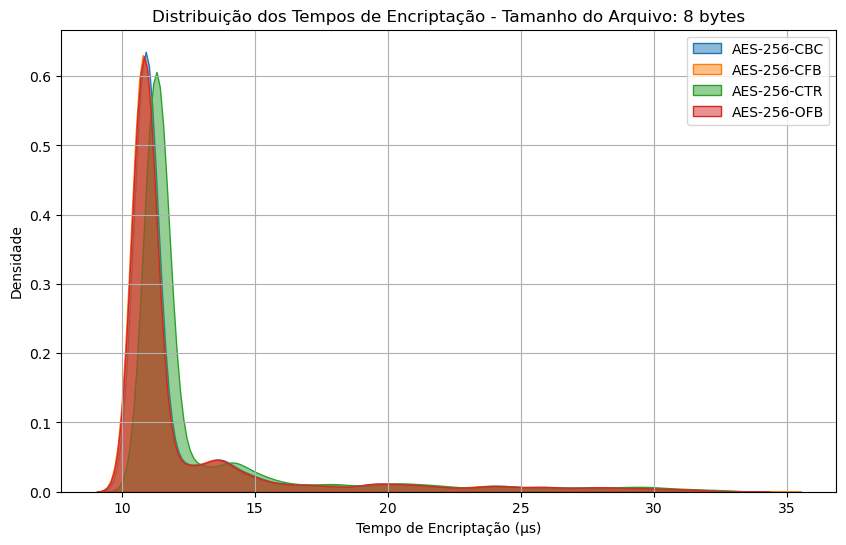

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pasta onde estão os arquivos CSV
stats_folder = "Stats"

# Modos de AES
aes_modes = ["CBC", "CFB", "CTR", "OFB"]

# Lê todos os arquivos CSV e combina os dados
dataframes = []
for mode in aes_modes:
    file_path = os.path.join(stats_folder, f"AES-256-{mode}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Mode"] = mode  # Adiciona uma coluna para identificar o modo
        dataframes.append(df)

# Combina todos os DataFrames em um único
data = pd.concat(dataframes, ignore_index=True)

# Lista de tamanhos de arquivos
file_sizes = data["File Size"].unique()

# Cria um gráfico de distribuição para cada tamanho de arquivo
for size in file_sizes:
    plt.figure(figsize=(10, 6))
    for mode in aes_modes:
        # Filtra os dados pelo tamanho do arquivo e pelo modo
        mode_data = data[(data["File Size"] == size) & (data["Mode"] == mode)]
        encryption_times = mode_data["Encryption Time"]

        # Conta a frequência de cada tempo de encriptação
        value_counts = encryption_times.value_counts()

        # Filtra apenas os tempos com mais de 50 amostras
        valid_times = value_counts[value_counts > 20].index
        filtered_data = encryption_times[encryption_times.isin(valid_times)]

        # Plota a distribuição dos tempos de encriptação usando KDE
        sns.kdeplot(filtered_data, label=f"AES-256-{mode}", fill=True, alpha=0.5)

    # Configurações do gráfico
    plt.title(f"Distribuição dos Tempos de Encriptação - Tamanho do Arquivo: {size} bytes")
    plt.xlabel("Tempo de Encriptação (µs)")
    plt.ylabel("Densidade")
    plt.legend()
    plt.grid(True)

    # Salva o gráfico como imagem
    output_path = os.path.join(stats_folder, f"encryption_distribution_{size}.png")
    plt.savefig(output_path)
    plt.show()

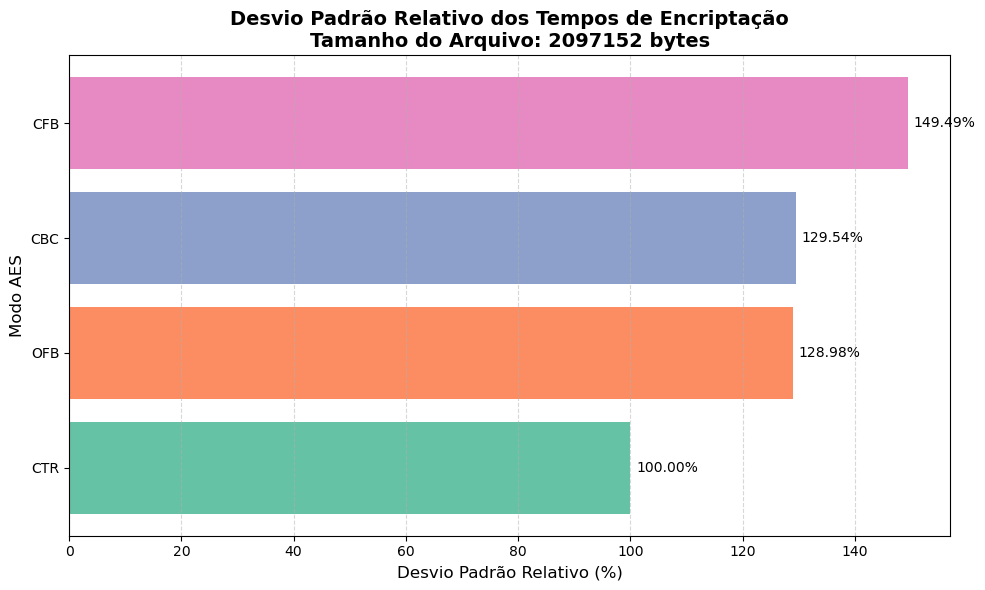

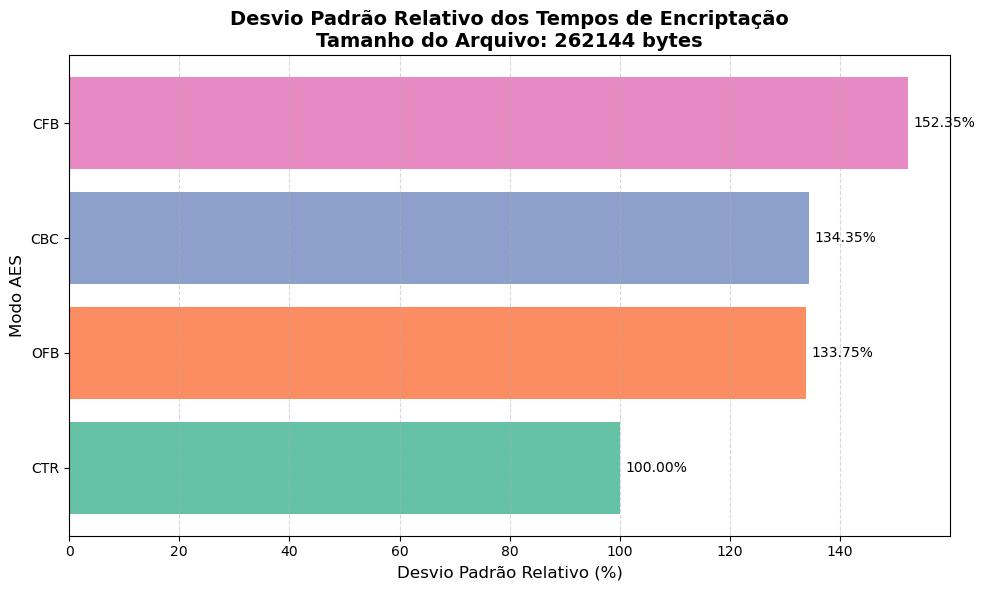

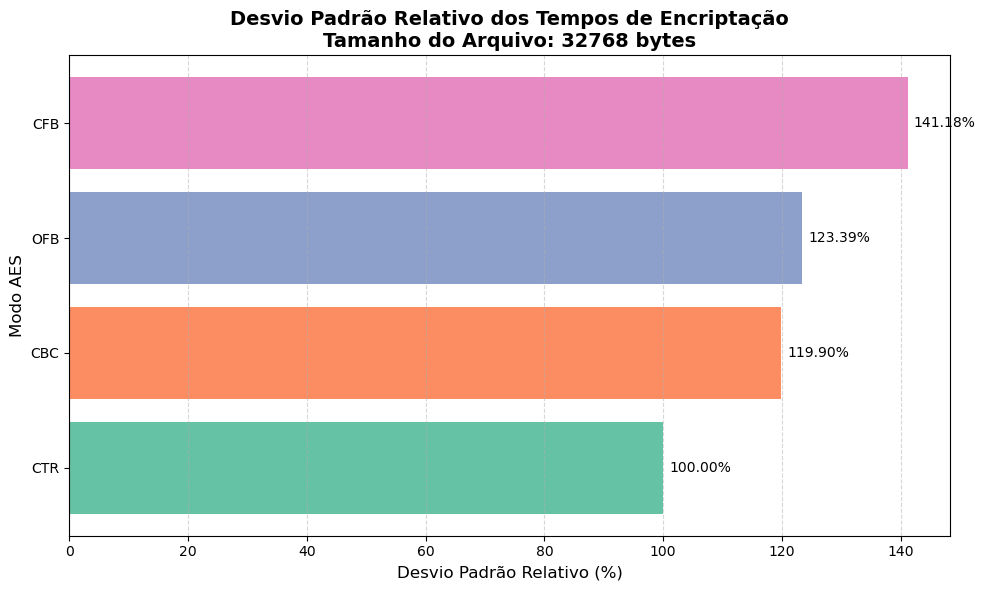

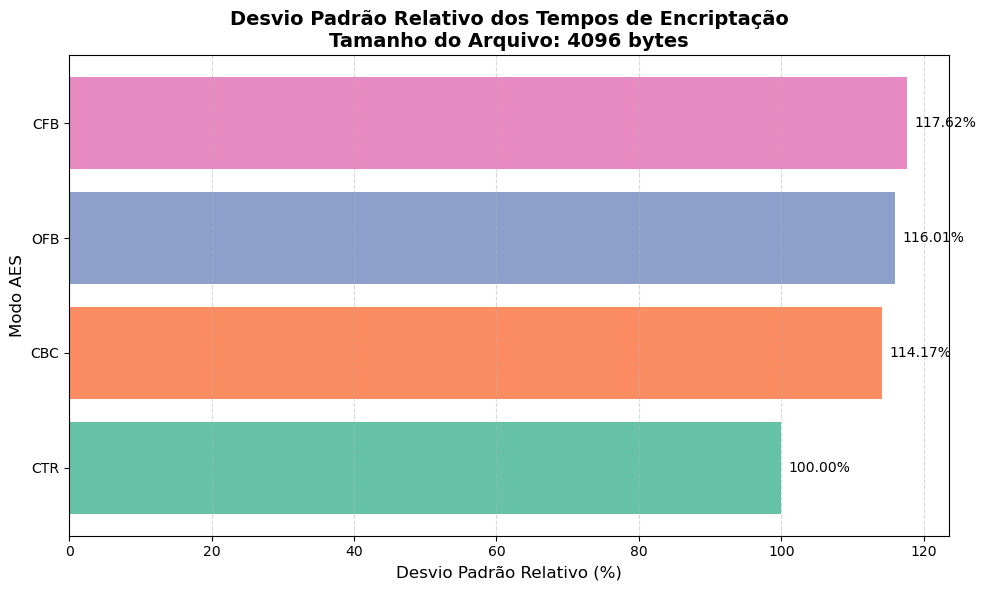

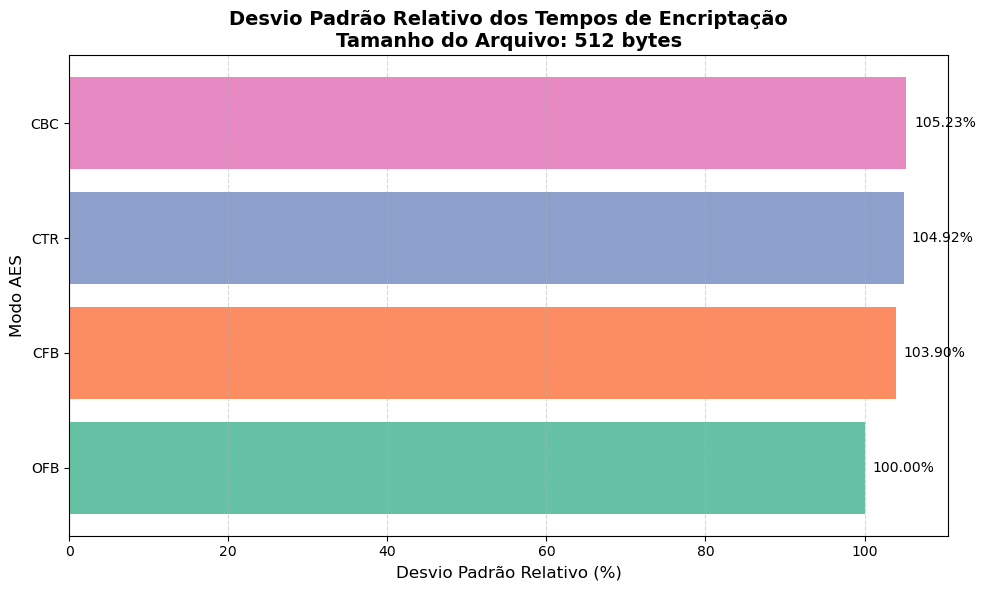

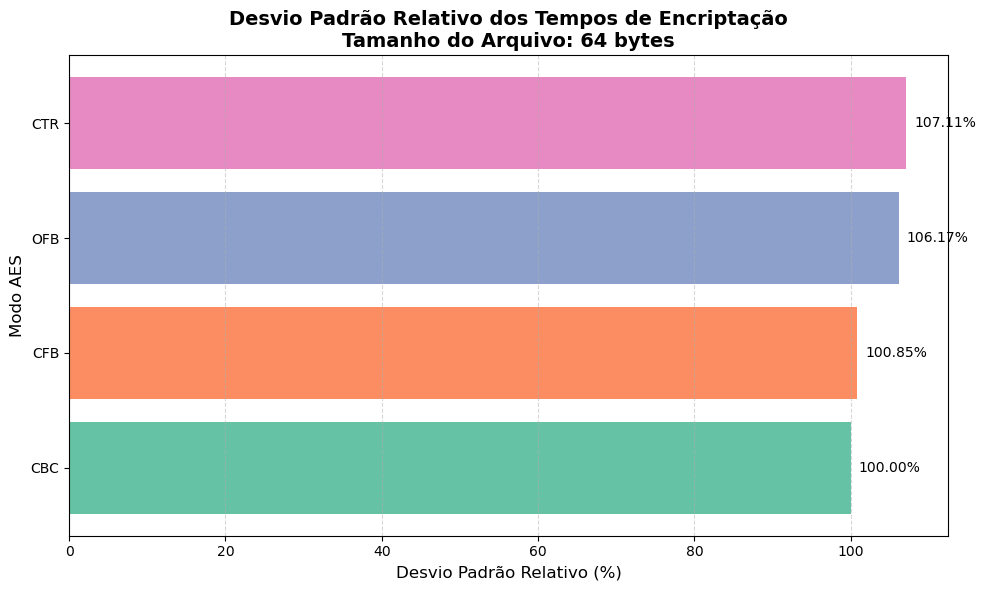

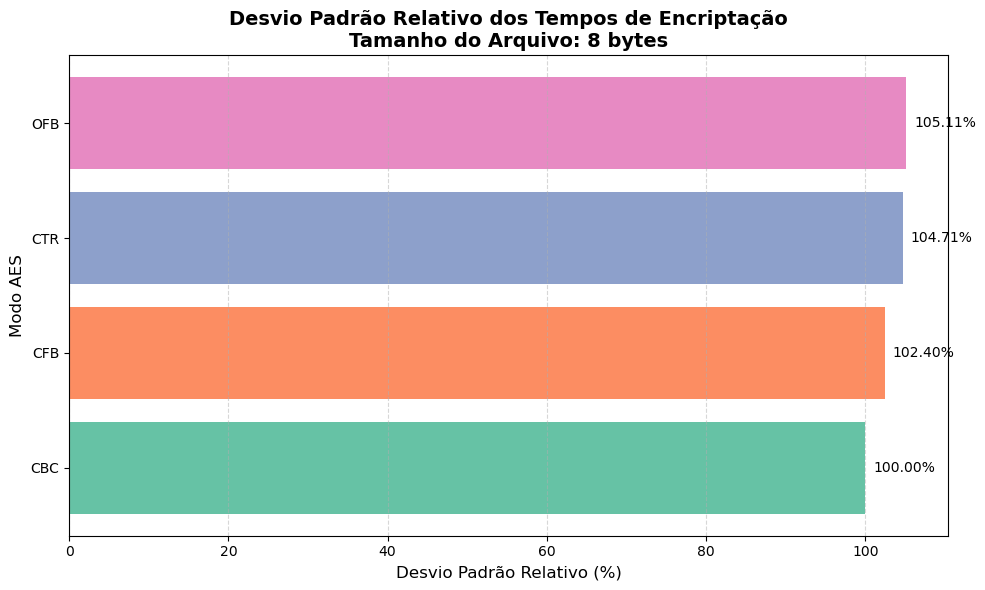

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ativa um estilo visual mais bonito
plt.style.use("seaborn-v0_8-muted")  # Estilo moderno

# Pasta onde estão os arquivos CSV
stats_folder = "Stats"

# Modos de AES
aes_modes = ["CBC", "CFB", "CTR", "OFB"]

# Lê todos os arquivos CSV e combina os dados
dataframes = []
for mode in aes_modes:
    file_path = os.path.join(stats_folder, f"AES-256-{mode}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Mode"] = mode
        dataframes.append(df)

# Combina todos os DataFrames em um único
data = pd.concat(dataframes, ignore_index=True)

# Lista de tamanhos de arquivos
file_sizes = data["File Size"].unique()

# Calcula os desvios padrão para cada modo e tamanho
std_devs = []
for size in file_sizes:
    for mode in aes_modes:
        mode_data = data[(data["File Size"] == size) & (data["Mode"] == mode)]
        encryption_times = mode_data["Encryption Time"]
        std_dev = encryption_times.std()
        std_devs.append({"File Size": size, "Mode": mode, "Std Dev": std_dev})

# Converte os resultados para um DataFrame
std_dev_df = pd.DataFrame(std_devs)

# Paleta de cores mais elegante
colors = sns.color_palette("Set2", len(aes_modes))

# Cria um gráfico de barras horizontais para cada tamanho de arquivo
for size in file_sizes:
    plt.figure(figsize=(10, 6))
    size_data = std_dev_df[std_dev_df["File Size"] == size].sort_values(by="Std Dev", ascending=True)

    base_std_dev = size_data["Std Dev"].iloc[0]
    size_data["Relative Std Dev (%)"] = (size_data["Std Dev"] / base_std_dev) * 100

    bars = plt.barh(size_data["Mode"], size_data["Relative Std Dev (%)"], color=colors)

    # Anota os valores nas barras
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height() / 2, f"{width:.2f}%", va='center', fontsize=10)

    plt.title(f"Desvio Padrão Relativo dos Tempos de Encriptação\nTamanho do Arquivo: {size} bytes", fontsize=14, weight='bold')
    plt.xlabel("Desvio Padrão Relativo (%)", fontsize=12)
    plt.ylabel("Modo AES", fontsize=12)
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()

    output_path = os.path.join(stats_folder, f"relative_std_dev_comparison_{size}.png")
    plt.savefig(output_path, dpi=300)
    plt.show()
